In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
hep.style.use("CMS")
from coffea import util
import itertools
import os, sys
import glob
import copy
from scipy.optimize import curve_fit


sys.path.append('../python/')
from functions import loadCoffeaFile, getLabelMap, getCoffeaFilenames, plotBackgroundEstimate, getHist, lumi


## analysis categories

In [2]:
IOV = '2016'

# analysis categories #

label_dict = loadCoffeaFile()['analysisCategories']

label_to_int_dict = {label: i for i, label in label_dict.items()}

signal_cats = [ i for label, i in label_to_int_dict.items() if '2t' in label]
pretag_cats = [ i for label, i in label_to_int_dict.items() if 'pre' in label]
antitag_cats = [ i for label, i in label_to_int_dict.items() if 'at' in label]


## scale factors

In [3]:
IOVs = ['2016']

lumi = {
    "2016APV": 19800.,
    "2016": 16120., #35920 - 19800
    "2016all": 35920,
    "2017": 41530.,
    "2018": 59740.
}

t_BR = 0.6741
ttbar_BR = 0.4544 #PDG 2019
ttbar_xs1 = 831.76 * (0.09210) #pb For ttbar mass from 700 to 1000
ttbar_xs2 = 831.76 * (0.02474) #pb For ttbar mass from 1000 to Inf
toptag_sf = 0.9
toptag_kf = 1.0 #0.7
qcd_xs = 13700000.0 #pb From https://cms-gen-dev.cern.ch/xsdb

zprime_xs = {
    '1000': 2.222,
    '1500': 0.387,
    '2000': 0.09428,
    '2500': 0.0279,
    '3000': 0.009327,
    '3500': 0.003507,
    '4000': 0.001484,
    '4500': 0.0007087,
    '5000': 0.0003801,
}






# transfer function

In [4]:
# fit N events from CR to N events from SR


# loose to fail | pretag to antitag

def rlf(x, mt, p0, p1):
    
    return x*(p0 + p1 * mt)


# pass to loose | signal to pretag

def rtl(x, mt, mtt, p2, p3, p4, p5):
    
    return x * (p2 + p3 * mt + p4 * mt * mt) * (p5 * mtt) 
    

In [5]:
mtt_vs_mt = getHist('mtt_vs_mt', 'JetHT', False, '2016', sum_axes=[], integrate_axes={})

# get 2d histograms of mt and mtt
h2dsr = mtt_vs_mt[{'anacat':signal_cats}][{'anacat':sum}]
h2dcr = mtt_vs_mt[{'anacat':antitag_cats}][{'anacat':sum}]
h2dpr = mtt_vs_mt[{'anacat':pretag_cats}][{'anacat':sum}]


hsig_mtt = h2dsr[{'jetmass':sum}]
hbkg_mtt = h2dcr[{'jetmass':sum}]


# N events in signal, antitag (control), and pretag region
Nsr = h2dsr.values()
Ncr = h2dcr.values()
Npr = h2dpr.values()


# 2d array of mt and mtt bins
bins_mt = h2dsr.axes['jetmass'].edges[:-1]
bins_mtt = h2dsr.axes['ttbarmass'].edges[:-1]
mtt, mt = np.meshgrid(bins_mtt, bins_mt)

# flatten arrays for fitting
f_mt  =  mt.flatten()
f_mtt = mtt.flatten()
f_nsr = Nsr.flatten()
f_ncr = Ncr.flatten()
f_npr = Npr.flatten()


/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


## fit the transfer functions

In [7]:
# loose to fail | pretag to antitag


y = np.where(f_ncr > 0, f_npr/f_ncr, 0)

popt, pcov = curve_fit(lambda x, p0, p1: rlf(x, f_mt, p0, p1), 
                       f_ncr, 
                       f_npr, 
                       p0=[1,1])


p0, p1 = popt

f_rlf = rlf(np.ones_like(Ncr), mt, p0, p1)



# pass to loose | signal to pretag


y = np.where(f_npr > 0, f_nsr/f_npr, 0)





popt, pcov = curve_fit(lambda x, p2, p3, p4, p5: rtl(x, f_mt, f_mtt, p2, p3, p4, p5), 
                       f_npr,
                       f_nsr,
                       p0=[1,1,1,1], bounds=[-10,10])


p2, p3, p4, p5 = popt

f_rtl = rtl(np.ones_like(Ncr), mt, mtt, p2, p3, p4, p5)


/tmp/ipykernel_4442/4214148893.py:4: RuntimeWarning: divide by zero encountered in divide
  y = np.where(f_ncr > 0, f_npr/f_ncr, 0)
/tmp/ipykernel_4442/4214148893.py:4: RuntimeWarning: invalid value encountered in divide
  y = np.where(f_ncr > 0, f_npr/f_ncr, 0)
/tmp/ipykernel_4442/4214148893.py:21: RuntimeWarning: invalid value encountered in divide
  y = np.where(f_npr > 0, f_nsr/f_npr, 0)


## plot data and background

/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


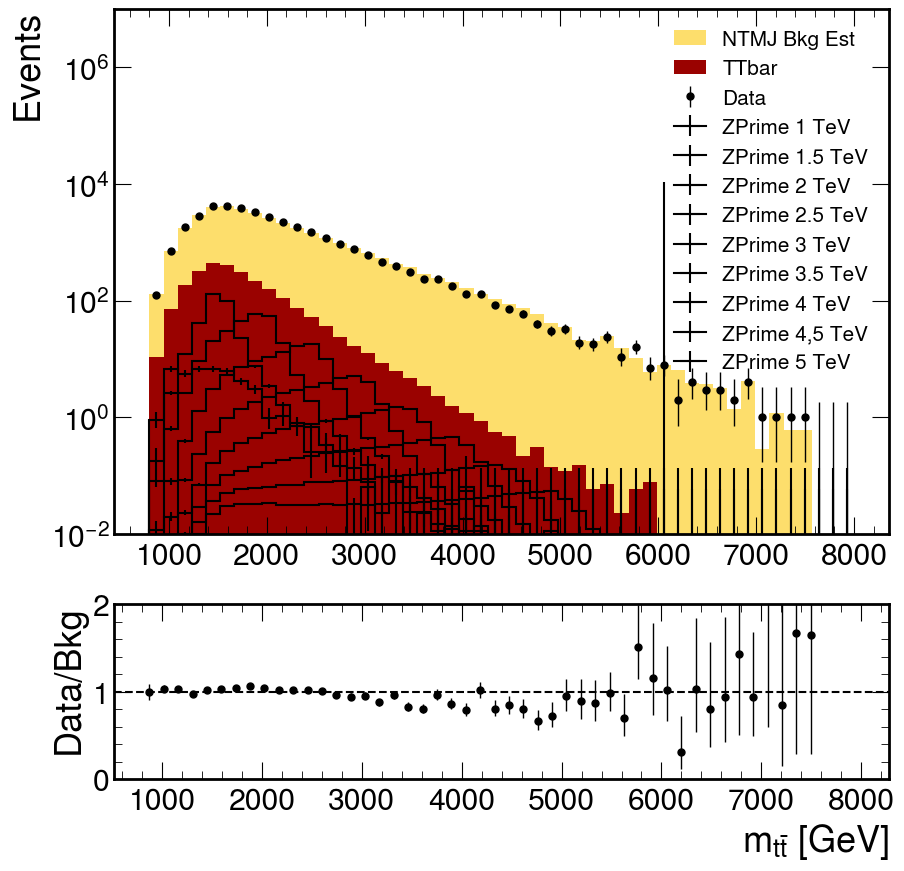

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])


bins = hbkg_mtt.axes['ttbarmass'].edges[:-1]


IOV = '2016'

httbar = getHist('ttbarmass', 'TTbar', False, IOV, sum_axes=['anacat','systematic'], integrate_axes={'anacat':signal_cats})
hdata  = getHist('ttbarmass', 'JetHT', False, IOV, sum_axes=['anacat','systematic'], integrate_axes={'anacat':signal_cats})


# h_mtt_mt = getHist('mtt_vs_mt', 'JetHT', False, IOV, sum_axes=['anacat','systematic'], integrate_axes={'anacat':pretag_cats})
h_mtt_mt = getHist('mtt_vs_mt', 'JetHT', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':pretag_cats})



hntmj_2d = h_mtt_mt * f_rlf
hntmj = hntmj_2d[{'jetmass':sum}]


hbkg = hntmj + httbar


Zprime1000file = util.load('../outputs/ZPrime1000_2016.coffea')
Zprime1500file = util.load('../outputs/ZPrime1500_2016.coffea')
Zprime2000file = util.load('../outputs/ZPrime2000_2016.coffea')
Zprime2500file = util.load('../outputs/ZPrime2500_2016.coffea')
Zprime3000file = util.load('../outputs/ZPrime3000_2016.coffea')
Zprime3500file = util.load('../outputs/ZPrime3500_2016.coffea')
Zprime4000file = util.load('../outputs/ZPrime4000_2016.coffea')
Zprime4500file = util.load('../outputs/ZPrime4500_2016.coffea')
Zprime5000file = util.load('../outputs/ZPrime5000_2016.coffea')





hZprime1000 = Zprime1000file['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}] * lumi['2016'] * zprime_xs['1000'] / Zprime1000file['cutflow']['sumw']
hZprime1500 = Zprime1500file['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}] * lumi['2016'] * zprime_xs['1500'] / Zprime1500file['cutflow']['sumw']
hZprime2000 = Zprime2000file['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}] * lumi['2016'] * zprime_xs['2000'] / Zprime2000file['cutflow']['sumw']
hZprime2500 = Zprime2500file['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}] * lumi['2016'] * zprime_xs['2500'] / Zprime2500file['cutflow']['sumw']
hZprime3000 = Zprime3000file['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}] * lumi['2016'] * zprime_xs['3000'] / Zprime3000file['cutflow']['sumw']
hZprime3500 = Zprime3500file['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}] * lumi['2016'] * zprime_xs['3500'] / Zprime3500file['cutflow']['sumw']
hZprime4000 = Zprime4000file['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}] * lumi['2016'] * zprime_xs['4000'] / Zprime4000file['cutflow']['sumw']
hZprime4500 = Zprime4500file['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}] * lumi['2016'] * zprime_xs['4500'] / Zprime4500file['cutflow']['sumw']
hZprime5000 = Zprime5000file['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum,'systematic':sum}] * lumi['2016'] * zprime_xs['5000'] / Zprime5000file['cutflow']['sumw']



hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')
hep.histplot(hbkg, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)
hep.histplot(hZprime1000, histtype='step', color='k', label='ZPrime 1 TeV', ax=ax1)
hep.histplot(hZprime1500, histtype='step', color='k', label='ZPrime 1.5 TeV', ax=ax1)
hep.histplot(hZprime2000, histtype='step', color='k', label='ZPrime 2 TeV', ax=ax1)
hep.histplot(hZprime2500, histtype='step', color='k', label='ZPrime 2.5 TeV', ax=ax1)
hep.histplot(hZprime3000, histtype='step', color='k', label='ZPrime 3 TeV', ax=ax1)
hep.histplot(hZprime3500, histtype='step', color='k', label='ZPrime 3.5 TeV', ax=ax1)
hep.histplot(hZprime4000, histtype='step', color='k', label='ZPrime 4 TeV', ax=ax1)
hep.histplot(hZprime4500, histtype='step', color='k', label='ZPrime 4,5 TeV', ax=ax1)
hep.histplot(hZprime5000, histtype='step', color='k', label='ZPrime 5 TeV', ax=ax1)





ax1.set_yscale('log')
ax1.set_ylim(1e-2,1e7)

ax1.set_ylabel('Events')

ratio_plot = hdata / hbkg.values()


hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(0,2)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')
ax2.set_xlabel(ax1.get_xlabel())
ax1.set_xlabel('')


ax1.legend(loc=1, fontsize=15)




In [ ]:
data_root_histname  = 'data_obs'  + '_' + 'inc' 
ntmj_root_histname  = 'ntmj'  + '_' + 'inc' 
ttbar_root_histname = 'ttbar' + '_' + 'inc'

print(data_root_histname)
print(ntmj_root_histname)
print(ttbar_root_histname)

In [ ]:




# f = uproot.recreate('test.root')
# f[data_root_histname] = hdata
# f[ttbar_root_histname] = httbar
# f[ntmj_root_histname] = hntmj
# f['ZPrime1000' + '_' + 'inc' ] = hZprime1000
# f['ZPrime1500' + '_' + 'inc' ] = hZprime1500
# f['ZPrime2000' + '_' + 'inc' ] = hZprime2000
# f['ZPrime2500' + '_' + 'inc' ] = hZprime2500
# f['ZPrime3000' + '_' + 'inc' ] = hZprime3000
# f['ZPrime3500' + '_' + 'inc' ] = hZprime3500
# f['ZPrime4000' + '_' + 'inc' ] = hZprime4000
# f['ZPrime4500' + '_' + 'inc' ] = hZprime4500
# f['ZPrime5000' + '_' + 'inc' ] = hZprime5000

# f.close()

## loop through analysis categories and systematics

In [12]:
# # cats = ['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']
# # cat_labels = ['cen0b', 'fwd0b', 'cen1b', 'fwd1b', 'cen2b', 'fwd2b']
# # systematics = ['nominal', 'pileup', 'prefiring', 'pdf']
# # syst_labels = ['nominal']
# # for s in systematics:
# #     if not 'nominal' in s:
# #         syst_labels.append(s+'Down')
# #         syst_labels.append(s+'Up')

        
        
        
# cats = ['0bcen']
# cat_labels = ['cen0b']
# systematics = ['nominal']
# syst_labels = ['nominal']
# for s in systematics:
#     if not 'nominal' in s:
#         syst_labels.append(s+'Down')
#         syst_labels.append(s+'Up')
# #         
        
# cats = ['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']
# cat_labels = ['cen0b', 'fwd0b', 'cen1b', 'fwd1b', 'cen2b', 'fwd2b']

In [20]:

# for cat, catname in zip(cats, cat_labels):
#     for syst in syst_labels:
        
        
#         fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])


#         signal_cat = label_to_int_dict['2t'+cat]
#         pretag_cat = label_to_int_dict['pret'+cat]
        
        
        
#         httbar = getHist('ttbarmass', 'TTbar', False, IOV, 
#                          sum_axes=[], 
#                          integrate_axes={'anacat':signal_cat,
#                                          'systematic':syst,
#                                         }
#                         )
        
        
#         httbar = getHist('ttbarmass', 'JetHT', False, IOV, 
#                          sum_axes=[], 
#                          integrate_axes={'anacat':signal_cat,
#                                          'systematic':syst,
#                                         }
#                         )
#         h_mtt_mt = getHist('mtt_vs_mt', 'JetHT', False, IOV, sum_axes=[], integrate_axes={})
        
        
#         hntmj_2d = h_mtt_mt * f_rlf
        
#         hntmj = hntmj_2d[{'anacat':signal_cat, 'jetmass':sum}]


#         hbkg = httbar + hntmj
        
        
#         hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')
#         hep.histplot(hbkg, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
#         hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)
        
        
#         ax1.set_yscale('log')
        
#         plt.plot()

        
        
        
        